## Compositional explanations for neurons

In [ ]:
import os
#virtually move to parent directory
os.chdir("..")

import torch
from itertools import permutations
from matplotlib import pyplot as plt

import clip
import utils
import data_utils
import similarity

## Settings

In [2]:
clip_name = 'ViT-B/16'
target_name = 'resnet50'
target_layer = 'layer4'
d_probe = 'imagenet_broden'
concept_set = 'data/20k.txt'

batch_size = 200
device = 'cuda'
pool_mode = 'avg'

save_dir = 'saved_activations'
similarity_fn = similarity.soft_wpmi

## Setup

In [3]:
utils.save_activations(clip_name = clip_name, target_name = target_name, target_layers = [target_layer], 
                       d_probe = d_probe, concept_set = concept_set, batch_size = batch_size, 
                       device = device, pool_mode=pool_mode, save_dir = save_dir)

save_names = utils.get_save_names(clip_name = clip_name, target_name = target_name,
                                  target_layer = target_layer, d_probe = d_probe,
                                  concept_set = concept_set, pool_mode=pool_mode,
                                  save_dir = save_dir)

target_save_name, clip_save_name, text_save_name = save_names

with open(concept_set, 'r') as f:
    words = f.read().split('\n')

pil_data = data_utils.get_data(d_probe)

## Find combination explanations using CLIP-Dissect

100%|██████████| 2048/2048 [00:11<00:00, 175.50it/s]


torch.Size([2048, 20000])


100%|██████████| 2048/2048 [00:06<00:00, 317.65it/s]


torch.Size([2048, 10000])

 Layer:layer4 Neuron:386
Top:1, Orig:textile, New:flores embroidery
Top:2, Orig:embroidered, New:motif embroidered


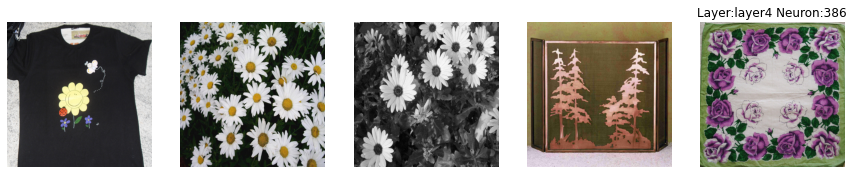

100%|██████████| 2048/2048 [00:09<00:00, 217.92it/s]


torch.Size([2048, 20000])


100%|██████████| 2048/2048 [00:05<00:00, 403.65it/s]


torch.Size([2048, 10000])

 Layer:layer4 Neuron:1617
Top:1, Orig:tournament, New:ping athlete
Top:2, Orig:ping, New:tournaments hannover


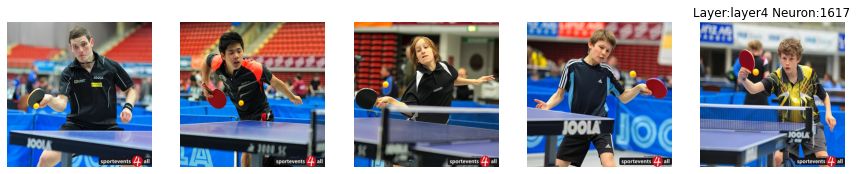

In [10]:
clip_model, clip_preprocess = clip.load(clip_name, device=device)
ids_of_interest = [386, 1617]

for id_of_interest in ids_of_interest:
    similarities, target_feats = utils.get_similarity_from_activations(target_save_name, clip_save_name, 
                                                                       text_save_name, similarity_fn, device=device)
    target_feats = target_feats.cpu()
    vals, ids = torch.topk(similarities[id_of_interest], k=5, largest=True)
    orig_words = [words[int(ids[i])] for i in range(len(vals))]

    vals, ids = similarities[id_of_interest].topk(100, largest=True)
    del similarities
    torch.cuda.empty_cache()
    
    #create new concept set
    top_words = [words[ind] for ind in ids]

    new_words = permutations(top_words, r=2)
    new_words = [word1+' '+word2 for word1, word2 in new_words]
    new_words.extend(top_words)
    
    #recalculate similarities
    text = clip.tokenize(["{}".format(word) for word in new_words]).to(device)
    with torch.no_grad():
        image_features = torch.load(clip_save_name)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        
        text_features = utils.get_clip_text_features(clip_model, text, batch_size=1000)
        text_features /= text_features.norm(dim=-1, keepdim=True)
    clip_feats = (image_features @ text_features.T).cpu().float()
    del image_features, text_features
    torch.cuda.empty_cache()
    
    similarities = similarity_fn(clip_feats, target_feats)
    top_vals, top_ids = torch.topk(target_feats, k=5, dim=0)

    print('\n Layer:{} Neuron:{}'.format(target_layer, (int(id_of_interest))))
    
    vals, ids = torch.topk(similarities[id_of_interest], k=2, largest=True)
    del similarities, clip_feats
    torch.cuda.empty_cache()
    
    for i in range(len(vals)):
        print("Top:{}, Orig:{}, New:{}".format(i+1, orig_words[i], new_words[int(ids[i])]))

    fig = plt.figure(figsize=(15, 7))
    for i, top_id in enumerate(top_ids[:, id_of_interest]):
        im, label = pil_data[top_id]
        im = im.resize([375,375])
        fig.add_subplot(1, 5, i+1)
        plt.imshow(im)
        plt.axis('off')
        
    plt.title('Layer:{} Neuron:{}'.format(target_layer, (int(id_of_interest))))
    plt.show()